<a href="https://colab.research.google.com/github/ericyoc/Optimal_Stock_Selec_Monte_Carlo_SIM/blob/main/Optimal_Stock_Selec_Monte_Carlo_SIM_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import List, Tuple
from scipy import stats

Yahoo Finance is a popular source for free financial data. It provides historical stock prices, financial statements, and other market data for a wide range of securities. The yfinance library is an unofficial Python wrapper for Yahoo Finance's API, making it easy to access this data programmatically.

For educational purposes and general analysis, Yahoo Finance data accessed through yfinance is typically sufficient and widely used.

In [3]:
def fetch_stock_data(tickers: List[str], start_date: str, end_date: str) -> pd.DataFrame:
    """Fetch stock data for given tickers and date range."""
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data.dropna(axis=1)  # Remove any columns with NaN values

In [4]:
def calculate_returns(data: pd.DataFrame) -> pd.DataFrame:
    """Calculate daily returns for each stock."""
    return data.pct_change().dropna()

In [5]:
def monte_carlo_simulation(returns: pd.DataFrame, num_simulations: int, num_days: int) -> dict:
    """Perform Monte Carlo simulations for each stock."""
    simulations = {}
    for ticker in returns.columns:
        stock_returns = returns[ticker].values
        if len(stock_returns) > 0:
            simulations[ticker] = np.random.choice(stock_returns, (num_simulations, num_days)).cumsum(axis=1)
    return simulations

In [6]:
def calculate_sharpe_ratio(returns: np.ndarray, risk_free_rate: float = 0.02) -> float:
    """Calculate Sharpe ratio for a given set of returns."""
    mean_return = np.mean(returns)
    std_dev = np.std(returns)
    return (mean_return - risk_free_rate) / std_dev if std_dev != 0 else 0

In [7]:
def find_optimal_stock(simulations: dict) -> Tuple[str, float]:
    """Find the optimal stock based on the highest Sharpe ratio."""
    sharpe_ratios = {}
    for ticker, sim in simulations.items():
        final_returns = sim[:, -1]
        sharpe_ratios[ticker] = calculate_sharpe_ratio(final_returns)
    optimal_stock = max(sharpe_ratios, key=sharpe_ratios.get)
    return optimal_stock, sharpe_ratios[optimal_stock]

In [8]:
def plot_simulations(simulations: dict, optimal_stock: str):
    """Plot Monte Carlo simulations and highlight the optimal stock."""
    plt.figure(figsize=(12, 8))
    for ticker, sim in simulations.items():
        if ticker == optimal_stock:
            plt.plot(sim.T, color='red', alpha=0.1)
        else:
            plt.plot(sim.T, color='blue', alpha=0.1)

    plt.title("Monte Carlo Simulations")
    plt.xlabel("Days")
    plt.ylabel("Cumulative Returns")
    plt.legend([f"Other Stocks", f"Optimal Stock: {optimal_stock}"])
    plt.show()

In [9]:
def calculate_sma(data: pd.Series, window: int) -> pd.Series:
    """Calculate Simple Moving Average"""
    return data.rolling(window=window).mean()

In [10]:
def calculate_ema(data: pd.Series, span: int) -> pd.Series:
    """Calculate Exponential Moving Average"""
    return data.ewm(span=span, adjust=False).mean()

In [11]:
def calculate_linear_regression(data: pd.Series) -> pd.Series:
    """Calculate Linear Regression line"""
    x = np.arange(len(data))
    slope, intercept, _, _, _ = stats.linregress(x, data)
    return pd.Series(slope * x + intercept, index=data.index)

In [12]:
def plot_optimal_stock_price(data: pd.DataFrame, optimal_stock: str):
    """Plot the optimal stock's price over time with trend lines."""
    stock_data = data[optimal_stock]

    plt.figure(figsize=(14, 8))

    # Plot the stock price
    plt.plot(stock_data.index, stock_data, label='Stock Price', color='blue')

    # Calculate and plot SMA (50-day)
    sma_50 = calculate_sma(stock_data, 50)
    plt.plot(sma_50.index, sma_50, label='50-day SMA', color='red', linestyle='--')

    # Calculate and plot EMA (20-day)
    ema_20 = calculate_ema(stock_data, 20)
    plt.plot(ema_20.index, ema_20, label='20-day EMA', color='green', linestyle='--')

    # Calculate and plot Linear Regression line
    lr_line = calculate_linear_regression(stock_data)
    plt.plot(lr_line.index, lr_line, label='Linear Regression', color='purple', linestyle='-.')

    plt.title(f"{optimal_stock} Stock Price Over Time with Trend Lines")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
def explain_optimal_stock_selection(data: pd.DataFrame, returns: pd.DataFrame, simulations: dict, optimal_stock: str, analysis_date: str):
    """Provide a detailed explanation of the optimal stock selection."""
    explanations = []
    metrics = {}

    for ticker in returns.columns:
        stock_returns = returns[ticker]
        total_return = (data[ticker].iloc[-1] / data[ticker].iloc[0] - 1) * 100
        volatility = stock_returns.std() * np.sqrt(252)  # Annualized volatility
        sharpe_ratio = calculate_sharpe_ratio(simulations[ticker][:, -1])

        metrics[ticker] = {
            "Total Return (%)": total_return,
            "Annualized Volatility (%)": volatility * 100,
            "Sharpe Ratio": sharpe_ratio
        }

    # Create a DataFrame for easy comparison
    metrics_df = pd.DataFrame(metrics).T
    metrics_df = metrics_df.sort_values("Sharpe Ratio", ascending=False)

    explanations.append(f"Analysis performed on: {analysis_date}")
    explanations.append("\nComparison of key metrics for all stocks:")
    explanations.append(metrics_df.to_string())
    explanations.append("\nExplanation of the optimal stock selection:")
    explanations.append(f"{optimal_stock} was selected as the optimal stock based on the following factors:")
    explanations.append(f"1. Highest Sharpe Ratio: {metrics[optimal_stock]['Sharpe Ratio']:.4f}")
    explanations.append("   The Sharpe ratio measures the risk-adjusted return, with a higher value indicating better risk-adjusted performance.")
    explanations.append(f"2. Total Return: {metrics[optimal_stock]['Total Return (%)']:.2f}%")
    explanations.append(f"3. Annualized Volatility: {metrics[optimal_stock]['Annualized Volatility (%)']:.2f}%")
    explanations.append("\nThe optimal stock provides the best balance between return and risk among the analyzed stocks.")

    # Add trend line explanation
    explanations.append("\nTrend Line Analysis:")
    explanations.append("1. 50-day Simple Moving Average (SMA): Represents the average price over the last 50 days, smoothing out short-term fluctuations.")
    explanations.append("2. 20-day Exponential Moving Average (EMA): Gives more weight to recent prices, responding more quickly to price changes than SMA.")
    explanations.append("3. Linear Regression Line: Shows the overall trend of the stock price over the analyzed period.")
    explanations.append("\nThese trend lines can help identify the overall direction of the stock price and potential support/resistance levels.")

    # Add validity period estimation
    explanations.append("\nValidity of the analysis:")
    explanations.append("This analysis is based on historical data and Monte Carlo simulations.")
    explanations.append("It should be considered valid for short-term decision making, typically 1-3 months.")
    explanations.append("However, market conditions can change rapidly, so regular reassessment is recommended.")
    explanations.append("For long-term investment decisions, consider performing this analysis quarterly or semi-annually.")

    return "\n".join(explanations)

In [14]:
def main():
    # Parameters
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TMUS']
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
    num_simulations = 1000
    num_days = 252  # Typical number of trading days in a year

    # Current date for analysis
    analysis_date = datetime.now().strftime('%Y-%m-%d')

    # Fetch stock data
    data = fetch_stock_data(tickers, start_date, end_date)

    # Calculate returns
    returns = calculate_returns(data)

    # Perform Monte Carlo simulations
    simulations = monte_carlo_simulation(returns, num_simulations, num_days)

    if not simulations:
        print("No valid stock data available for simulation.")
        return

    # Find optimal stock
    optimal_stock, sharpe_ratio = find_optimal_stock(simulations)

    # Print results
    print(f"Optimal stock: {optimal_stock}")
    print(f"Sharpe ratio: {sharpe_ratio:.4f}")

    # Explain optimal stock selection
    explanation = explain_optimal_stock_selection(data, returns, simulations, optimal_stock, analysis_date)
    print("\nDetailed Explanation:")
    print(explanation)

    # Plot simulations
    plot_simulations(simulations, optimal_stock)

    # Plot optimal stock price over time
    plot_optimal_stock_price(data, optimal_stock)

[*********************100%%**********************]  6 of 6 completed


Optimal stock: TMUS
Sharpe ratio: 1.8955

Detailed Explanation:
Analysis performed on: 2024-07-04

Comparison of key metrics for all stocks:
       Total Return (%)  Annualized Volatility (%)  Sharpe Ratio
TMUS          29.436088                  13.431913      1.895519
META          73.593753                  35.664313      1.645508
AMZN          51.549309                  27.924973      1.597160
MSFT          37.327942                  20.172428      1.582808
GOOGL         52.799403                  27.727339      1.574370
AAPL          16.409660                  22.065042      0.676498

Explanation of the optimal stock selection:
TMUS was selected as the optimal stock based on the following factors:
1. Highest Sharpe Ratio: 1.8955
   The Sharpe ratio measures the risk-adjusted return, with a higher value indicating better risk-adjusted performance.
2. Total Return: 29.44%
3. Annualized Volatility: 13.43%

The optimal stock provides the best balance between return and risk among the 

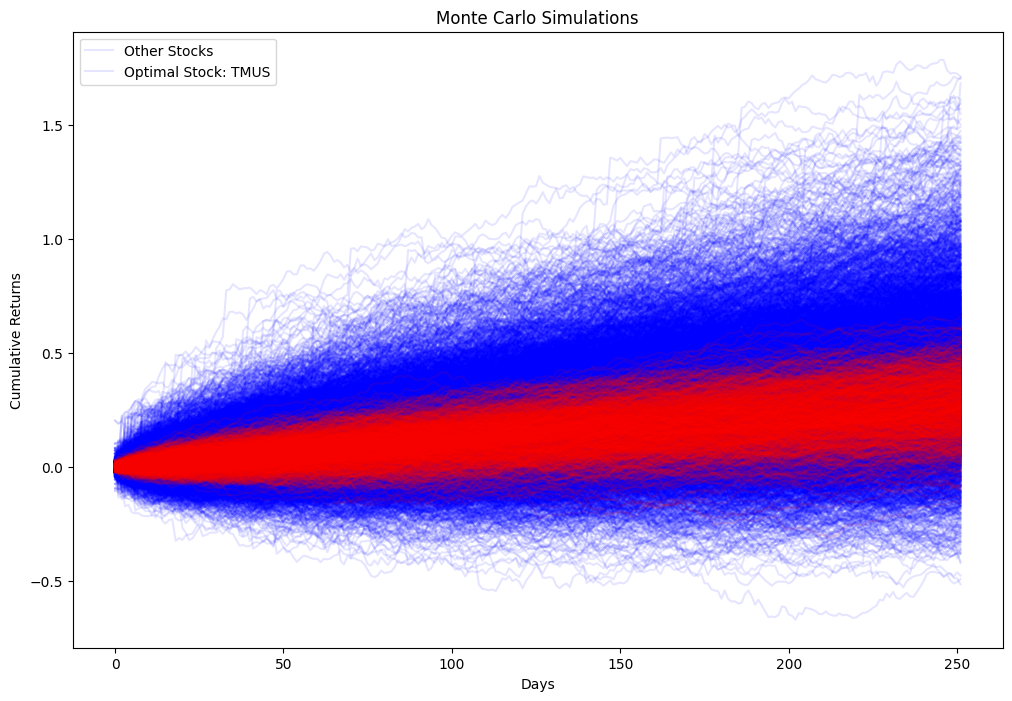

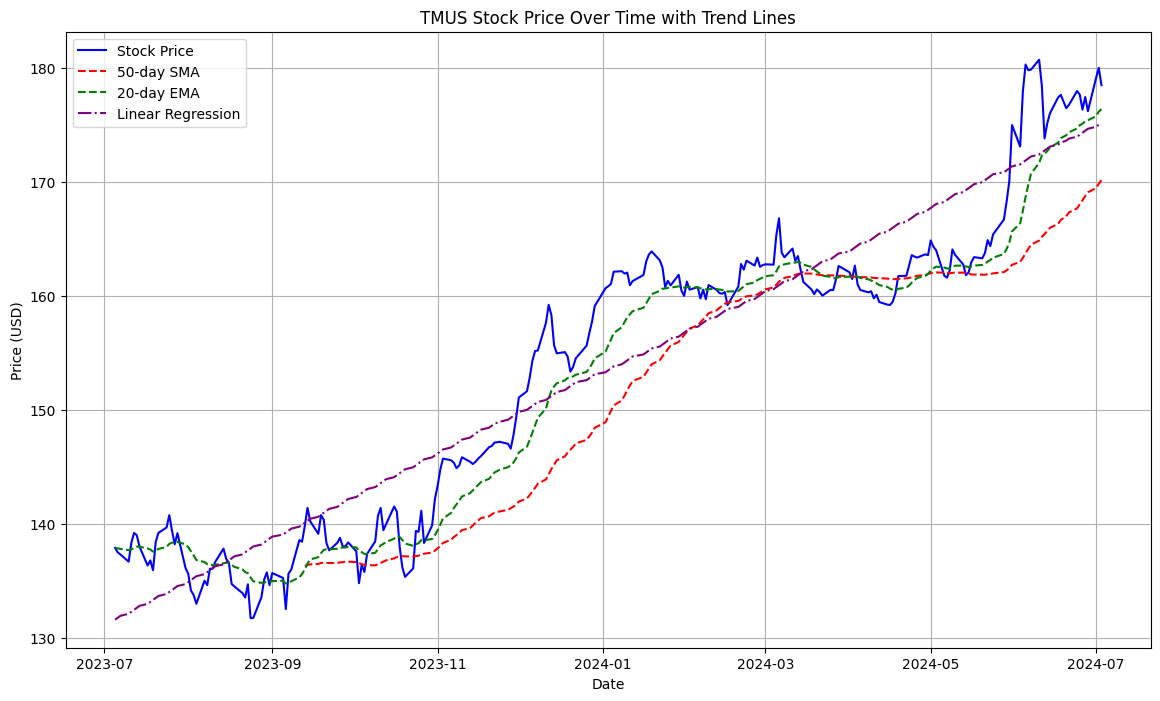

In [15]:
if __name__ == "__main__":
    main()